In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
from catboost import CatBoostClassifier, cv, Pool
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
%matplotlib inline 

In [2]:
train = pd.read_csv('train.csv', sep = '\t', index_col = 0)
test = pd.read_csv('test.csv', sep = '\t', index_col = 0)

In [3]:
def submission(y, subm_name):
    pd.Series(y, name = '_VAL_').to_csv(subm_name, index_label = '_ID_', header = True)

## PREPROCESSING

In [4]:
useless_columns = ['9', '140', '152', '160', '164'] 
one_test = ['11']
zero_test = ['5', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305']

In [5]:
train = train.drop(useless_columns, axis = 1)
test = test.drop(useless_columns, axis = 1)
for column in zero_test:
    train = train[train[column] == 0].drop(column, axis = 1)
    test.drop(column, axis = 1, inplace = True)
for column in one_test:
    train = train[train[column] == 1].drop(column, axis = 1)
    test.drop(column, axis = 1, inplace = True)
X = train.drop('0', axis=1).reset_index(drop = True)
y = train['0'].reset_index(drop = True)
X_test = test.drop('0', axis=1).reset_index(drop = True)

In [6]:
X.shape, X_test.shape

((30377, 322), (4166, 322))

## Validation

In [7]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

## BASELINE

In [8]:
xgb_train = xgb.DMatrix(X, y, feature_names = X.columns)
xgb_test = xgb.DMatrix(X_test, feature_names = X.columns)

In [9]:
n_rounds = 10000
params_xgb = {   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    'nthread': -1,
    'random_seed': 42,
    'eval_metric': 'auc',
   
    'max_depth':  9,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.75,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

In [42]:
results_xgb = xgb.cv(params_xgb, xgb_train, num_boost_round = n_rounds, folds = list(skf.split(X,y)), early_stopping_rounds = 20, verbose_eval=1)

[0]	train-auc:0.709103+0.00277736	test-auc:0.676326+0.00532408
[1]	train-auc:0.7301+0.00235167	test-auc:0.694411+0.00441693
[2]	train-auc:0.740865+0.00268048	test-auc:0.703094+0.00289487
[3]	train-auc:0.745732+0.00124512	test-auc:0.706408+0.00393024
[4]	train-auc:0.749292+0.00249185	test-auc:0.708055+0.00463706
[5]	train-auc:0.752114+0.00302396	test-auc:0.708925+0.00446068
[6]	train-auc:0.753744+0.0027232	test-auc:0.710089+0.00463778
[7]	train-auc:0.755145+0.00241794	test-auc:0.71117+0.00514868
[8]	train-auc:0.756895+0.00261939	test-auc:0.712662+0.00513991
[9]	train-auc:0.758447+0.00267015	test-auc:0.71424+0.00501912
[10]	train-auc:0.759469+0.00220022	test-auc:0.71394+0.0054711
[11]	train-auc:0.759854+0.00204001	test-auc:0.714417+0.00529318
[12]	train-auc:0.760039+0.0023617	test-auc:0.714334+0.00539943
[13]	train-auc:0.76025+0.0023874	test-auc:0.714722+0.00509934
[14]	train-auc:0.760794+0.00202928	test-auc:0.715507+0.00515338
[15]	train-auc:0.761053+0.00220319	test-auc:0.715778+0.00522

[129]	train-auc:0.800132+0.00101714	test-auc:0.727549+0.00547507
[130]	train-auc:0.800404+0.000954669	test-auc:0.727571+0.00548784
[131]	train-auc:0.800656+0.00101487	test-auc:0.727616+0.00550464
[132]	train-auc:0.800969+0.00111228	test-auc:0.727681+0.0054687
[133]	train-auc:0.80132+0.00111561	test-auc:0.727698+0.00551572
[134]	train-auc:0.801539+0.00102569	test-auc:0.727699+0.00553034
[135]	train-auc:0.801798+0.00116047	test-auc:0.727775+0.00552922
[136]	train-auc:0.802084+0.00116267	test-auc:0.727794+0.00549876
[137]	train-auc:0.802463+0.00110078	test-auc:0.727913+0.00551627
[138]	train-auc:0.802725+0.00111274	test-auc:0.727924+0.00549047
[139]	train-auc:0.803127+0.00120788	test-auc:0.727994+0.00547895
[140]	train-auc:0.803562+0.00126511	test-auc:0.728085+0.00552395
[141]	train-auc:0.803782+0.00127621	test-auc:0.728159+0.00552502
[142]	train-auc:0.804108+0.00138293	test-auc:0.728188+0.00556151
[143]	train-auc:0.804556+0.00150677	test-auc:0.728295+0.00549943
[144]	train-auc:0.804849+0

[257]	train-auc:0.842081+0.0011357	test-auc:0.736062+0.00637854
[258]	train-auc:0.842377+0.0011818	test-auc:0.736149+0.00636888
[259]	train-auc:0.842658+0.0011842	test-auc:0.736238+0.00641827
[260]	train-auc:0.842932+0.00121326	test-auc:0.736308+0.0064413
[261]	train-auc:0.843247+0.00125994	test-auc:0.736326+0.00646247
[262]	train-auc:0.84357+0.00129057	test-auc:0.736384+0.00641101
[263]	train-auc:0.843836+0.00132131	test-auc:0.736476+0.00641559
[264]	train-auc:0.844156+0.00133324	test-auc:0.736508+0.00643039
[265]	train-auc:0.844498+0.00135241	test-auc:0.736602+0.00644615
[266]	train-auc:0.844825+0.00137612	test-auc:0.736595+0.00644195
[267]	train-auc:0.845123+0.00139002	test-auc:0.736701+0.00643301
[268]	train-auc:0.845447+0.00139777	test-auc:0.736714+0.00641516
[269]	train-auc:0.845781+0.00135156	test-auc:0.736833+0.00643891
[270]	train-auc:0.846104+0.0013512	test-auc:0.736865+0.00644137
[271]	train-auc:0.846439+0.00140072	test-auc:0.736967+0.00644372
[272]	train-auc:0.846673+0.0014

[384]	train-auc:0.875008+0.000845633	test-auc:0.740619+0.00660625
[385]	train-auc:0.875219+0.000862168	test-auc:0.740634+0.00658061
[386]	train-auc:0.87541+0.000846739	test-auc:0.740651+0.00653571
[387]	train-auc:0.875626+0.000825077	test-auc:0.740692+0.0065093
[388]	train-auc:0.875864+0.000813484	test-auc:0.740721+0.00648308
[389]	train-auc:0.876089+0.000830881	test-auc:0.740764+0.00647967
[390]	train-auc:0.87627+0.000824001	test-auc:0.740773+0.00648921
[391]	train-auc:0.8765+0.000813752	test-auc:0.740773+0.00651667
[392]	train-auc:0.876718+0.000817013	test-auc:0.740829+0.00654265
[393]	train-auc:0.8769+0.000832742	test-auc:0.74084+0.00656748
[394]	train-auc:0.877128+0.000836543	test-auc:0.74087+0.00656065
[395]	train-auc:0.877329+0.000852696	test-auc:0.740923+0.00655233
[396]	train-auc:0.877543+0.000883282	test-auc:0.74095+0.00657367
[397]	train-auc:0.87776+0.000886198	test-auc:0.741006+0.00659404
[398]	train-auc:0.877977+0.000883484	test-auc:0.741024+0.00658791
[399]	train-auc:0.878

[510]	train-auc:0.898695+0.000568432	test-auc:0.74306+0.00695797
[511]	train-auc:0.898892+0.000593469	test-auc:0.743049+0.00697911
[512]	train-auc:0.899091+0.000554357	test-auc:0.743025+0.00698749
[513]	train-auc:0.899239+0.000548563	test-auc:0.743036+0.00701189
[514]	train-auc:0.8994+0.00053834	test-auc:0.743074+0.00700037
[515]	train-auc:0.899534+0.000558366	test-auc:0.743113+0.00701958
[516]	train-auc:0.899679+0.000544184	test-auc:0.743111+0.00702545
[517]	train-auc:0.89993+0.000537652	test-auc:0.743084+0.00705079
[518]	train-auc:0.900099+0.000495865	test-auc:0.743111+0.0070663
[519]	train-auc:0.900289+0.000502834	test-auc:0.743128+0.00704999
[520]	train-auc:0.900432+0.000543373	test-auc:0.743132+0.00705002
[521]	train-auc:0.900624+0.000535543	test-auc:0.743116+0.00705204
[522]	train-auc:0.90078+0.000542106	test-auc:0.743121+0.00705058
[523]	train-auc:0.901005+0.000522835	test-auc:0.743139+0.00706865
[524]	train-auc:0.901161+0.000553913	test-auc:0.743125+0.00708997
[525]	train-auc:0

[635]	train-auc:0.917407+0.000596905	test-auc:0.744209+0.0071938
[636]	train-auc:0.917488+0.000587677	test-auc:0.744213+0.00721686
[637]	train-auc:0.917607+0.000583156	test-auc:0.744195+0.0071946
[638]	train-auc:0.917759+0.00058555	test-auc:0.744193+0.00720747
[639]	train-auc:0.917869+0.000583123	test-auc:0.744181+0.0072076
[640]	train-auc:0.917985+0.000592527	test-auc:0.744178+0.00719204
[641]	train-auc:0.918167+0.000584497	test-auc:0.744172+0.00720586
[642]	train-auc:0.918284+0.000621974	test-auc:0.744167+0.0072001
[643]	train-auc:0.91837+0.000641201	test-auc:0.744178+0.007215
[644]	train-auc:0.918492+0.00065489	test-auc:0.744218+0.00723362
[645]	train-auc:0.918629+0.00065705	test-auc:0.744216+0.00723028
[646]	train-auc:0.918758+0.000626513	test-auc:0.744217+0.00724913
[647]	train-auc:0.918924+0.000614718	test-auc:0.744247+0.00725677
[648]	train-auc:0.919072+0.000622375	test-auc:0.744226+0.00724705
[649]	train-auc:0.919192+0.000635842	test-auc:0.744242+0.00726771
[650]	train-auc:0.91

[761]	train-auc:0.93249+0.000529111	test-auc:0.744961+0.00738749
[762]	train-auc:0.932603+0.000525088	test-auc:0.744969+0.00737808
[763]	train-auc:0.932708+0.000509556	test-auc:0.744971+0.00738001
[764]	train-auc:0.932835+0.000481739	test-auc:0.745017+0.00738845
[765]	train-auc:0.932913+0.000505759	test-auc:0.745016+0.00738659
[766]	train-auc:0.933017+0.000511231	test-auc:0.745011+0.00737854
[767]	train-auc:0.933109+0.00049139	test-auc:0.74501+0.00739407
[768]	train-auc:0.933186+0.000489958	test-auc:0.745006+0.00739628
[769]	train-auc:0.933289+0.000485943	test-auc:0.745028+0.007415
[770]	train-auc:0.933406+0.000496675	test-auc:0.745021+0.00741346
[771]	train-auc:0.933477+0.000489005	test-auc:0.745017+0.00740005
[772]	train-auc:0.933573+0.000458878	test-auc:0.745025+0.00739134
[773]	train-auc:0.93369+0.000465837	test-auc:0.745038+0.00738598
[774]	train-auc:0.933839+0.000472225	test-auc:0.745014+0.0074011
[775]	train-auc:0.933958+0.000453906	test-auc:0.745007+0.0073936
[776]	train-auc:0.

### As a baseline on validation we have 0.745155 score on 811 iterations

## Dimension reduction

In [11]:
from sklearn.decomposition import PCA

In [12]:
dr = PCA(n_components = 2, random_state = 42)
dr.fit(X, y)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
Xdr2 = dr.transform(X)
Xdr2 = pd.DataFrame(Xdr2, columns = [str(col) for col in list(range(2))])
Xdr2

,0,1
0,0.812424,1.013743
1,1.202794,0.176006
2,1.314341,0.169012
3,1.031603,0.762871
4,1.418170,1.320273
5,-1.736812,1.462521
6,-1.799311,0.393557
7,1.335206,0.517093
8,-1.871410,0.470165
9,-1.852784,0.827645


In [14]:
Xdr2.columns

Index(['0', '1'], dtype='object')

In [15]:
Xdr2['target'] = y
Xdr2

,0,1,target
0,0.812424,1.013743,1
1,1.202794,0.176006,1
2,1.314341,0.169012,0
3,1.031603,0.762871,0
4,1.418170,1.320273,0
5,-1.736812,1.462521,0
6,-1.799311,0.393557,0
7,1.335206,0.517093,0
8,-1.871410,0.470165,0
9,-1.852784,0.827645,0


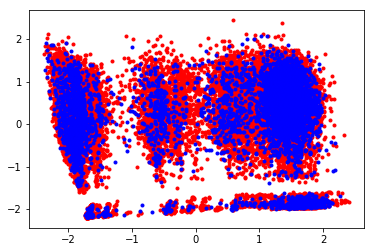

In [16]:
plt.plot(Xdr2[Xdr2.target == 0]['0'], Xdr2[Xdr2.target == 0]['1'], 'r.', Xdr2[Xdr2.target == 1]['0'], Xdr2[Xdr2.target == 1]['1'], 'b.')

Seems that in 2D we can't divide classes

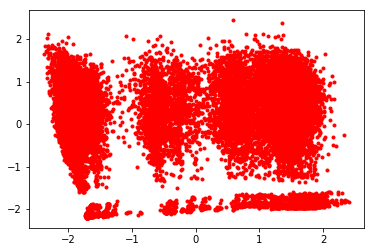

In [17]:
plt.plot(Xdr2[Xdr2.target == 0]['0'], Xdr2[Xdr2.target == 0]['1'], 'r.')

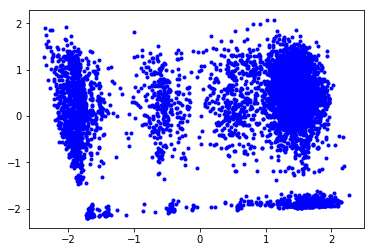

In [18]:
plt.plot(Xdr2[Xdr2.target == 1]['0'], Xdr2[Xdr2.target == 1]['1'], 'b.')

In [22]:
et = ExtraTreesClassifier(n_estimators = 100, max_depth = 8)
cv = cross_val_score(et, Xdr2.drop(['target'], axis = 1), y, scoring = 'roc_auc', cv = skf, verbose = 2)
cv

[CV]  ................................................................
[CV] ................................................. , total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.6s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished


array([0.62791367, 0.62342731, 0.63788247, 0.6331944 , 0.63280177])

In [23]:
from sklearn.model_selection import cross_val_predict

In [24]:
Xdr = X.copy()
Xdr['et'] = cross_val_predict(et, Xdr2.drop(['target'], axis = 1), y, method = 'predict_proba', cv = skf)[:,1]
Xdr

,1,2,3,4,6,7,8,10,12,13,...,337,338,339,340,341,342,343,344,345,et
0,1,0,0,0,0,0.090909,0,1,1,0.461538,...,0,1,0,0,0.222222,1,1,1,1,0.204698
1,1,0,0,1,0,0.090909,0,1,1,0.187500,...,0,1,0,0,0.111111,1,1,1,0,0.258301
2,1,0,0,1,0,0.090909,0,1,1,0.200000,...,0,1,0,0,0.444444,1,1,1,1,0.260176
3,1,0,0,1,0,0.136364,0,1,1,0.000000,...,0,0,1,0,0.222222,1,1,1,0,0.217864
4,1,0,0,1,0,0.136364,0,1,1,0.650000,...,0,0,1,0,0.111111,1,1,1,1,0.252558
5,1,0,0,0,0,0.090909,0,0,1,0.026316,...,0,0,0,0,0.000000,1,1,1,0,0.123322
6,1,0,0,0,0,0.090909,0,1,1,0.666667,...,1,0,0,0,0.000000,1,1,1,0,0.123565
7,1,0,0,1,0,0.090909,0,1,1,0.142857,...,0,1,0,0,0.000000,1,1,1,0,0.265508
8,1,0,0,0,0,0.090909,0,1,1,0.769231,...,1,0,0,0,0.000000,1,1,1,1,0.117406
9,1,0,0,0,0,0.136364,0,1,1,0.285714,...,1,0,0,0,0.000000,1,1,1,0,0.104271


In [25]:
xgb_xdr = xgb.DMatrix(Xdr, y, feature_names = list(Xdr.columns))

In [80]:
results_xgb = xgb.cv(params_xgb, xgb_xdr, num_boost_round = n_rounds, folds = list(skf.split(Xdr,y)), early_stopping_rounds = 20, verbose_eval = 1)

[0]	train-auc:0.704312+0.00221479	test-auc:0.673815+0.00735517
[1]	train-auc:0.725764+0.00291791	test-auc:0.690659+0.00995235
[2]	train-auc:0.737914+0.00385927	test-auc:0.699678+0.00918352
[3]	train-auc:0.746244+0.00397322	test-auc:0.704425+0.00797278
[4]	train-auc:0.750066+0.00382419	test-auc:0.708149+0.0100955
[5]	train-auc:0.752586+0.00356301	test-auc:0.709151+0.00846969
[6]	train-auc:0.75445+0.00409885	test-auc:0.710559+0.00760551
[7]	train-auc:0.755713+0.00422727	test-auc:0.710676+0.00756168
[8]	train-auc:0.757363+0.00417909	test-auc:0.71055+0.00654914
[9]	train-auc:0.758536+0.00411007	test-auc:0.711397+0.00723857
[10]	train-auc:0.759484+0.0039754	test-auc:0.71202+0.00722018
[11]	train-auc:0.760711+0.00463099	test-auc:0.71209+0.00723883
[12]	train-auc:0.761438+0.00479751	test-auc:0.712754+0.00761315
[13]	train-auc:0.761431+0.00492108	test-auc:0.712608+0.00733935
[14]	train-auc:0.761879+0.00515995	test-auc:0.713196+0.0078508
[15]	train-auc:0.76229+0.00499846	test-auc:0.713366+0.007

[129]	train-auc:0.803202+0.00319455	test-auc:0.726894+0.00882018
[130]	train-auc:0.803512+0.00317608	test-auc:0.727043+0.00890417
[131]	train-auc:0.803864+0.00322905	test-auc:0.727145+0.00884499
[132]	train-auc:0.804235+0.00317912	test-auc:0.727232+0.00900359
[133]	train-auc:0.804488+0.00321641	test-auc:0.727361+0.00900194
[134]	train-auc:0.804696+0.0032437	test-auc:0.727424+0.00900766
[135]	train-auc:0.805063+0.00324133	test-auc:0.727551+0.00902244
[136]	train-auc:0.805402+0.00314344	test-auc:0.727545+0.00892242
[137]	train-auc:0.805698+0.00312344	test-auc:0.727615+0.0089886
[138]	train-auc:0.806006+0.00305516	test-auc:0.727745+0.00897652
[139]	train-auc:0.806293+0.00308125	test-auc:0.72781+0.0090544
[140]	train-auc:0.80659+0.00312613	test-auc:0.727904+0.00908443
[141]	train-auc:0.806992+0.00310523	test-auc:0.727995+0.00914951
[142]	train-auc:0.807274+0.00309238	test-auc:0.72803+0.00915916
[143]	train-auc:0.807634+0.00298572	test-auc:0.728071+0.00920434
[144]	train-auc:0.807904+0.0029

[257]	train-auc:0.843049+0.00213776	test-auc:0.734891+0.00959151
[258]	train-auc:0.843357+0.00216047	test-auc:0.734891+0.00957461
[259]	train-auc:0.84363+0.00222381	test-auc:0.734906+0.00952413
[260]	train-auc:0.843953+0.00225368	test-auc:0.735006+0.00957561
[261]	train-auc:0.844289+0.00219437	test-auc:0.735032+0.00957901
[262]	train-auc:0.844637+0.00218109	test-auc:0.735105+0.00959463
[263]	train-auc:0.844922+0.00221171	test-auc:0.735097+0.00956938
[264]	train-auc:0.845123+0.00218865	test-auc:0.735133+0.00957878
[265]	train-auc:0.845387+0.00219616	test-auc:0.735176+0.00954197
[266]	train-auc:0.84571+0.0021847	test-auc:0.735233+0.0095609
[267]	train-auc:0.84601+0.00215305	test-auc:0.735289+0.00953602
[268]	train-auc:0.846299+0.00215993	test-auc:0.735366+0.00956054
[269]	train-auc:0.846605+0.00215876	test-auc:0.735407+0.00958152
[270]	train-auc:0.846916+0.00217673	test-auc:0.735508+0.00960298
[271]	train-auc:0.847237+0.00216563	test-auc:0.735548+0.00961529
[272]	train-auc:0.847535+0.002

[384]	train-auc:0.876266+0.00227723	test-auc:0.739744+0.0094293
[385]	train-auc:0.876483+0.00229399	test-auc:0.739779+0.00943569
[386]	train-auc:0.876704+0.00230076	test-auc:0.739774+0.00944464
[387]	train-auc:0.876932+0.00227056	test-auc:0.739811+0.0094484
[388]	train-auc:0.877145+0.00229177	test-auc:0.739798+0.0094635
[389]	train-auc:0.877314+0.00231879	test-auc:0.739846+0.00946975
[390]	train-auc:0.877543+0.00237261	test-auc:0.739842+0.0095037
[391]	train-auc:0.877772+0.00239797	test-auc:0.739866+0.00949659
[392]	train-auc:0.877986+0.00235693	test-auc:0.739894+0.00952818
[393]	train-auc:0.878192+0.0023465	test-auc:0.739902+0.00954009
[394]	train-auc:0.878425+0.00236862	test-auc:0.739905+0.00955944
[395]	train-auc:0.878656+0.0023448	test-auc:0.739925+0.00963737
[396]	train-auc:0.878901+0.0023392	test-auc:0.739973+0.00966967
[397]	train-auc:0.879112+0.00234538	test-auc:0.739991+0.0096633
[398]	train-auc:0.879281+0.0023058	test-auc:0.739996+0.00962139
[399]	train-auc:0.879507+0.0022969

[512]	train-auc:0.900494+0.00185948	test-auc:0.741861+0.00979901
[513]	train-auc:0.900661+0.00186538	test-auc:0.741867+0.00981374
[514]	train-auc:0.900806+0.00191113	test-auc:0.741882+0.00982954
[515]	train-auc:0.900979+0.00192875	test-auc:0.741915+0.00985324
[516]	train-auc:0.901126+0.00192524	test-auc:0.741956+0.00984625
[517]	train-auc:0.901272+0.00194036	test-auc:0.741966+0.00983818
[518]	train-auc:0.90144+0.0019093	test-auc:0.741971+0.00984884
[519]	train-auc:0.901617+0.00191953	test-auc:0.741985+0.0098599
[520]	train-auc:0.901781+0.00191086	test-auc:0.741969+0.00991482
[521]	train-auc:0.901941+0.00187979	test-auc:0.741962+0.00990176
[522]	train-auc:0.902091+0.00189798	test-auc:0.741983+0.00987265
[523]	train-auc:0.902261+0.00186849	test-auc:0.741972+0.00990832
[524]	train-auc:0.902386+0.00190141	test-auc:0.741964+0.00991654
[525]	train-auc:0.902525+0.00187751	test-auc:0.741971+0.00991987
[526]	train-auc:0.902693+0.00185842	test-auc:0.741985+0.00991169
[527]	train-auc:0.902905+0.0

[640]	train-auc:0.919221+0.00149267	test-auc:0.743049+0.0100996
[641]	train-auc:0.919384+0.00148949	test-auc:0.743071+0.010095
[642]	train-auc:0.919527+0.00148918	test-auc:0.743059+0.0101016
[643]	train-auc:0.919658+0.00148237	test-auc:0.743057+0.0100987
[644]	train-auc:0.919801+0.00142573	test-auc:0.743069+0.0100965
[645]	train-auc:0.919934+0.00142723	test-auc:0.743084+0.010068
[646]	train-auc:0.920112+0.00143919	test-auc:0.743088+0.0100664
[647]	train-auc:0.920234+0.00142831	test-auc:0.74307+0.0100732
[648]	train-auc:0.920343+0.00142933	test-auc:0.743058+0.0100601
[649]	train-auc:0.920486+0.00141161	test-auc:0.743036+0.0100535
[650]	train-auc:0.920647+0.00143346	test-auc:0.743018+0.0100631
[651]	train-auc:0.920772+0.00143655	test-auc:0.743038+0.0100637
[652]	train-auc:0.92092+0.00145528	test-auc:0.743069+0.0100602
[653]	train-auc:0.921009+0.00144774	test-auc:0.743094+0.0100654
[654]	train-auc:0.921125+0.00144467	test-auc:0.743101+0.0100826
[655]	train-auc:0.921226+0.00144802	test-auc

### Result: In 2D we can't divide classes and model based on this additional 2D X doesn't improve score

## Let's check clustering

In [136]:
from sklearn.cluster import KMeans

km = KMeans(
    n_jobs = -1,
)
km.fit(X.values)
cluster_labels = km.predict(X.values)
test_labels = km.predict(X_test.values)
# check statistics
print('Clusters found: {}'.format(np.unique(cluster_labels).shape[0]))
pd.Series(cluster_labels).value_counts()

Clusters found: 8


1    6672
0    5807
4    4315
5    3980
6    3417
7    3056
2    1590
3    1540
dtype: int64

In [137]:
y.corr(pd.Series(cluster_labels))

-0.06259002433296197

In [138]:
X_clust = X.copy()
X_clust['labels'] = cluster_labels
X_clust

,1,2,3,4,6,7,8,10,12,13,...,337,338,339,340,341,342,343,344,345,labels
0,1,0,0,0,0,0.090909,0,1,1,0.461538,...,0,1,0,0,0.222222,1,1,1,1,1
1,1,0,0,1,0,0.090909,0,1,1,0.187500,...,0,1,0,0,0.111111,1,1,1,0,1
2,1,0,0,1,0,0.090909,0,1,1,0.200000,...,0,1,0,0,0.444444,1,1,1,1,1
3,1,0,0,1,0,0.136364,0,1,1,0.000000,...,0,0,1,0,0.222222,1,1,1,0,5
4,1,0,0,1,0,0.136364,0,1,1,0.650000,...,0,0,1,0,0.111111,1,1,1,1,1
5,1,0,0,0,0,0.090909,0,0,1,0.026316,...,0,0,0,0,0.000000,1,1,1,0,4
6,1,0,0,0,0,0.090909,0,1,1,0.666667,...,1,0,0,0,0.000000,1,1,1,0,0
7,1,0,0,1,0,0.090909,0,1,1,0.142857,...,0,1,0,0,0.000000,1,1,1,0,5
8,1,0,0,0,0,0.090909,0,1,1,0.769231,...,1,0,0,0,0.000000,1,1,1,1,4
9,1,0,0,0,0,0.136364,0,1,1,0.285714,...,1,0,0,0,0.000000,1,1,1,0,4


In [139]:
xgb_c = xgb.DMatrix(X_clust, y, feature_names = list(X_clust.columns))

In [140]:
results_xgb = xgb.cv(params_xgb, xgb_c, num_boost_round = n_rounds, folds = list(skf.split(X_clust, y)), early_stopping_rounds = 20, verbose_eval = 1)

[0]	train-auc:0.705454+0.00429502	test-auc:0.673708+0.00665588
[1]	train-auc:0.728438+0.00477231	test-auc:0.690197+0.00955085
[2]	train-auc:0.737148+0.0045165	test-auc:0.697803+0.0105397
[3]	train-auc:0.745948+0.00191281	test-auc:0.705073+0.00704099
[4]	train-auc:0.748603+0.00248531	test-auc:0.70722+0.00626128
[5]	train-auc:0.75198+0.00252284	test-auc:0.709528+0.00682604
[6]	train-auc:0.754814+0.00225527	test-auc:0.710961+0.00713823
[7]	train-auc:0.756634+0.00213616	test-auc:0.712295+0.00612633
[8]	train-auc:0.758145+0.00311561	test-auc:0.713043+0.00625484
[9]	train-auc:0.759753+0.00235522	test-auc:0.714346+0.00630874
[10]	train-auc:0.760262+0.00198955	test-auc:0.714293+0.00597402
[11]	train-auc:0.760968+0.0017336	test-auc:0.715032+0.00650654
[12]	train-auc:0.761639+0.00165424	test-auc:0.715163+0.00600445
[13]	train-auc:0.761791+0.00178658	test-auc:0.715361+0.00589115
[14]	train-auc:0.762912+0.00215943	test-auc:0.715821+0.00558036
[15]	train-auc:0.763451+0.0025464	test-auc:0.716189+0.0

[129]	train-auc:0.801549+0.00177741	test-auc:0.728158+0.00579033
[130]	train-auc:0.80184+0.0018038	test-auc:0.728212+0.00580769
[131]	train-auc:0.802203+0.00184342	test-auc:0.728284+0.00575857
[132]	train-auc:0.802479+0.00190623	test-auc:0.728414+0.00572359
[133]	train-auc:0.802793+0.00182956	test-auc:0.728495+0.0056758
[134]	train-auc:0.803055+0.00178549	test-auc:0.728553+0.00564655
[135]	train-auc:0.803384+0.00179579	test-auc:0.728603+0.00564509
[136]	train-auc:0.803725+0.00169006	test-auc:0.728708+0.00565794
[137]	train-auc:0.804049+0.00175292	test-auc:0.728787+0.00571839
[138]	train-auc:0.804338+0.0017242	test-auc:0.728875+0.00569039
[139]	train-auc:0.804621+0.00172696	test-auc:0.728941+0.00571251
[140]	train-auc:0.804866+0.00165557	test-auc:0.729049+0.00578286
[141]	train-auc:0.80535+0.00157126	test-auc:0.729138+0.00582909
[142]	train-auc:0.805643+0.00163875	test-auc:0.729211+0.00579624
[143]	train-auc:0.806031+0.00160201	test-auc:0.72924+0.00576507
[144]	train-auc:0.806295+0.0016

[256]	train-auc:0.842694+0.00134348	test-auc:0.737092+0.00562611
[257]	train-auc:0.842986+0.00129683	test-auc:0.737121+0.00561026
[258]	train-auc:0.843259+0.00135044	test-auc:0.737179+0.00564534
[259]	train-auc:0.843554+0.00131162	test-auc:0.73719+0.00567491
[260]	train-auc:0.843797+0.00130736	test-auc:0.737222+0.00561837
[261]	train-auc:0.844095+0.00135939	test-auc:0.737231+0.00560817
[262]	train-auc:0.844437+0.00138203	test-auc:0.737297+0.00562806
[263]	train-auc:0.844777+0.00139115	test-auc:0.737353+0.00562861
[264]	train-auc:0.845122+0.00137433	test-auc:0.737433+0.0056437
[265]	train-auc:0.845445+0.00138193	test-auc:0.737476+0.00563784
[266]	train-auc:0.845714+0.00136258	test-auc:0.737521+0.00560085
[267]	train-auc:0.846011+0.00133171	test-auc:0.737523+0.00559909
[268]	train-auc:0.846299+0.00134671	test-auc:0.737592+0.00562301
[269]	train-auc:0.846592+0.00134299	test-auc:0.737637+0.00569146
[270]	train-auc:0.846867+0.00132651	test-auc:0.737685+0.00569022
[271]	train-auc:0.847188+0.

[383]	train-auc:0.875778+0.000818818	test-auc:0.741445+0.00572839
[384]	train-auc:0.875937+0.000830489	test-auc:0.741468+0.00572625
[385]	train-auc:0.876157+0.00084235	test-auc:0.74152+0.00570526
[386]	train-auc:0.876363+0.000858932	test-auc:0.741527+0.0056675
[387]	train-auc:0.876591+0.000846549	test-auc:0.741562+0.0057197
[388]	train-auc:0.876803+0.000877973	test-auc:0.741603+0.00571099
[389]	train-auc:0.877007+0.000856011	test-auc:0.741598+0.00574085
[390]	train-auc:0.877233+0.000857827	test-auc:0.741612+0.00576657
[391]	train-auc:0.877447+0.00087833	test-auc:0.74166+0.00577166
[392]	train-auc:0.87767+0.000894686	test-auc:0.741681+0.00580138
[393]	train-auc:0.877869+0.000943087	test-auc:0.741699+0.00577266
[394]	train-auc:0.878097+0.000907416	test-auc:0.741714+0.00576483
[395]	train-auc:0.878348+0.00093027	test-auc:0.741747+0.00572155
[396]	train-auc:0.878575+0.000938905	test-auc:0.741776+0.00571606
[397]	train-auc:0.878769+0.000958949	test-auc:0.741803+0.00573416
[398]	train-auc:0.

[509]	train-auc:0.899659+0.000381248	test-auc:0.743562+0.00648976
[510]	train-auc:0.899776+0.000404989	test-auc:0.743619+0.00647216
[511]	train-auc:0.899921+0.000390355	test-auc:0.74365+0.00645319
[512]	train-auc:0.900088+0.000364516	test-auc:0.74366+0.00644475
[513]	train-auc:0.900272+0.000362653	test-auc:0.743707+0.00643616
[514]	train-auc:0.900426+0.000367748	test-auc:0.743711+0.00646389
[515]	train-auc:0.900599+0.000384608	test-auc:0.743759+0.00647738
[516]	train-auc:0.900771+0.00039782	test-auc:0.743788+0.006484
[517]	train-auc:0.900929+0.000395618	test-auc:0.743771+0.00649085
[518]	train-auc:0.901106+0.000361635	test-auc:0.743784+0.00648545
[519]	train-auc:0.901231+0.000369324	test-auc:0.743788+0.00648865
[520]	train-auc:0.90139+0.000349622	test-auc:0.743769+0.00646483
[521]	train-auc:0.901544+0.000371313	test-auc:0.743805+0.00646816
[522]	train-auc:0.901702+0.000361663	test-auc:0.743804+0.00646449
[523]	train-auc:0.90184+0.000376713	test-auc:0.743792+0.00649673
[524]	train-auc:0

[634]	train-auc:0.917587+0.000447911	test-auc:0.744951+0.00688099
[635]	train-auc:0.917684+0.000440568	test-auc:0.744954+0.00689071
[636]	train-auc:0.917838+0.000454968	test-auc:0.744992+0.00687867
[637]	train-auc:0.917969+0.000457833	test-auc:0.744999+0.00686744
[638]	train-auc:0.918084+0.000424115	test-auc:0.745011+0.00688219
[639]	train-auc:0.918229+0.000446274	test-auc:0.745006+0.00689415
[640]	train-auc:0.918377+0.00043142	test-auc:0.745014+0.00690571
[641]	train-auc:0.918513+0.000425719	test-auc:0.745036+0.00689035
[642]	train-auc:0.918685+0.000422715	test-auc:0.745033+0.00689492
[643]	train-auc:0.918798+0.000382179	test-auc:0.745042+0.00689422
[644]	train-auc:0.918913+0.000361693	test-auc:0.745026+0.00690192
[645]	train-auc:0.919013+0.000372593	test-auc:0.745011+0.00688625
[646]	train-auc:0.919148+0.000310863	test-auc:0.745021+0.006893
[647]	train-auc:0.919293+0.000333566	test-auc:0.745021+0.00688979
[648]	train-auc:0.919403+0.000322876	test-auc:0.74504+0.0068902
[649]	train-auc

[760]	train-auc:0.932212+0.000614543	test-auc:0.745549+0.00707004
[761]	train-auc:0.932306+0.000636064	test-auc:0.74554+0.00707809
[762]	train-auc:0.93242+0.000658151	test-auc:0.745554+0.00706667
[763]	train-auc:0.932534+0.000648403	test-auc:0.745528+0.00706649
[764]	train-auc:0.932634+0.00068177	test-auc:0.745521+0.00704085
[765]	train-auc:0.932748+0.000653996	test-auc:0.745536+0.00705392
[766]	train-auc:0.932861+0.000687891	test-auc:0.74554+0.00705974
[767]	train-auc:0.932954+0.000700651	test-auc:0.745544+0.00705456
[768]	train-auc:0.933075+0.000680279	test-auc:0.745554+0.00708447
[769]	train-auc:0.933168+0.000679969	test-auc:0.745556+0.00708486


### Result: 0.745584 _ 749 iterations, this score is slightly better than baseline

## Feature selection

In [25]:
from sklearn.feature_selection import SelectKBest, f_classif
Xkbest = SelectKBest(f_classif, k = 200).fit_transform(X, y)

In [26]:
Xkbest = pd.DataFrame(Xkbest, columns = [str(col) for col in list(range(200))])
Xkbest.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.0,0.0,0.0,0.0,0.090909,0.0,1.0,1.0,0.461538,0.0,...,0.178935,0.221395,0.0,1.0,0.0,0.222222,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,0.0,0.090909,0.0,1.0,1.0,0.187500,0.0,...,0.110012,0.241508,0.0,1.0,0.0,0.111111,1.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.090909,0.0,1.0,1.0,0.200000,0.0,...,0.025786,0.123067,0.0,1.0,0.0,0.444444,1.0,1.0,1.0,1.0
3,1.0,0.0,1.0,0.0,0.136364,0.0,1.0,1.0,0.000000,0.0,...,0.116122,0.296065,0.0,0.0,1.0,0.222222,1.0,1.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.136364,0.0,1.0,1.0,0.650000,0.0,...,0.039169,0.178956,0.0,0.0,1.0,0.111111,1.0,1.0,1.0,1.0


In [27]:
xgb_kbest = xgb.DMatrix(Xkbest, y, feature_names = list(Xkbest.columns))

In [28]:
results_xgb = xgb.cv(params_xgb, xgb_kbest, num_boost_round = n_rounds, folds = list(skf.split(Xkbest,y)), early_stopping_rounds = 20, verbose_eval = 1)

[0]	train-auc:0.715628+0.00439149	test-auc:0.683369+0.00848751
[1]	train-auc:0.734158+0.00563564	test-auc:0.700388+0.00706132
[2]	train-auc:0.741807+0.00219377	test-auc:0.704317+0.0086469
[3]	train-auc:0.745765+0.00239676	test-auc:0.705974+0.00802385
[4]	train-auc:0.748221+0.0027064	test-auc:0.70746+0.00719377
[5]	train-auc:0.751167+0.00171737	test-auc:0.709084+0.00703533
[6]	train-auc:0.753124+0.00158153	test-auc:0.709949+0.00700683
[7]	train-auc:0.754031+0.00190569	test-auc:0.710736+0.00708002
[8]	train-auc:0.755448+0.00200097	test-auc:0.712143+0.0070713
[9]	train-auc:0.756505+0.00180861	test-auc:0.712944+0.00731765
[10]	train-auc:0.757559+0.00197108	test-auc:0.713827+0.00669829
[11]	train-auc:0.758013+0.00159693	test-auc:0.714234+0.00636872
[12]	train-auc:0.758365+0.00142508	test-auc:0.71465+0.00609772
[13]	train-auc:0.758769+0.00125634	test-auc:0.71514+0.00629557
[14]	train-auc:0.759137+0.00133485	test-auc:0.716064+0.00603843
[15]	train-auc:0.759517+0.00136261	test-auc:0.716324+0.0

[129]	train-auc:0.796068+0.00158523	test-auc:0.727893+0.00454789
[130]	train-auc:0.796289+0.00160507	test-auc:0.727932+0.00457801
[131]	train-auc:0.796571+0.00156708	test-auc:0.72805+0.00464982
[132]	train-auc:0.796941+0.00143713	test-auc:0.728216+0.0046981
[133]	train-auc:0.797255+0.00138603	test-auc:0.728294+0.00474634
[134]	train-auc:0.79772+0.00146105	test-auc:0.728341+0.00473644
[135]	train-auc:0.798015+0.00131818	test-auc:0.728454+0.00482416
[136]	train-auc:0.798413+0.00135325	test-auc:0.728538+0.00483789
[137]	train-auc:0.798635+0.0013825	test-auc:0.728542+0.0048454
[138]	train-auc:0.798945+0.00138385	test-auc:0.728565+0.00493239
[139]	train-auc:0.799201+0.00137061	test-auc:0.728596+0.00491389
[140]	train-auc:0.799514+0.00128416	test-auc:0.728666+0.00493043
[141]	train-auc:0.799854+0.00116973	test-auc:0.728775+0.00496447
[142]	train-auc:0.800167+0.00116116	test-auc:0.728868+0.0049759
[143]	train-auc:0.800478+0.00121059	test-auc:0.728945+0.00498998
[144]	train-auc:0.800799+0.0012

[255]	train-auc:0.834842+0.000587625	test-auc:0.73624+0.00580083
[256]	train-auc:0.835107+0.000562899	test-auc:0.736262+0.00580633
[257]	train-auc:0.835377+0.000607942	test-auc:0.736282+0.00580876
[258]	train-auc:0.835699+0.000591648	test-auc:0.736307+0.00576628
[259]	train-auc:0.835975+0.00058089	test-auc:0.736391+0.00572855
[260]	train-auc:0.836231+0.000582969	test-auc:0.736392+0.00571895
[261]	train-auc:0.836503+0.000592734	test-auc:0.736424+0.0057191
[262]	train-auc:0.836788+0.00056618	test-auc:0.736491+0.00571715
[263]	train-auc:0.83706+0.000604627	test-auc:0.736543+0.00573222
[264]	train-auc:0.83733+0.000666481	test-auc:0.736591+0.0057219
[265]	train-auc:0.837555+0.000633157	test-auc:0.736641+0.00572188
[266]	train-auc:0.837836+0.000641923	test-auc:0.736641+0.00569051
[267]	train-auc:0.838118+0.000661975	test-auc:0.736705+0.00564787
[268]	train-auc:0.838364+0.000650566	test-auc:0.736734+0.0056278
[269]	train-auc:0.838649+0.000691382	test-auc:0.736801+0.00561902
[270]	train-auc:0.

[381]	train-auc:0.864565+0.000938014	test-auc:0.740549+0.00592642
[382]	train-auc:0.86478+0.000927062	test-auc:0.740558+0.00593892
[383]	train-auc:0.864991+0.000892325	test-auc:0.740608+0.00598034
[384]	train-auc:0.865191+0.000873566	test-auc:0.740632+0.00597389
[385]	train-auc:0.865355+0.000896316	test-auc:0.740629+0.00595283
[386]	train-auc:0.865538+0.000895159	test-auc:0.740629+0.00595645
[387]	train-auc:0.865743+0.000883724	test-auc:0.740646+0.00598901
[388]	train-auc:0.865923+0.000875453	test-auc:0.740689+0.00601
[389]	train-auc:0.866143+0.000824745	test-auc:0.740707+0.00600022
[390]	train-auc:0.866316+0.000845303	test-auc:0.740732+0.00598037
[391]	train-auc:0.866533+0.000830926	test-auc:0.740757+0.00599019
[392]	train-auc:0.86676+0.000845992	test-auc:0.740798+0.00599228
[393]	train-auc:0.866939+0.000878418	test-auc:0.740841+0.00599243
[394]	train-auc:0.867104+0.000900534	test-auc:0.740823+0.0060144
[395]	train-auc:0.867299+0.000930822	test-auc:0.740867+0.00604552
[396]	train-auc:

[508]	train-auc:0.886588+0.00112446	test-auc:0.742463+0.00609314
[509]	train-auc:0.886723+0.00110103	test-auc:0.742473+0.00610237
[510]	train-auc:0.886876+0.00111673	test-auc:0.742486+0.00610103
[511]	train-auc:0.887008+0.00113381	test-auc:0.742495+0.00611904
[512]	train-auc:0.887173+0.00114438	test-auc:0.742506+0.00612817
[513]	train-auc:0.88733+0.0011105	test-auc:0.742505+0.00612591
[514]	train-auc:0.887487+0.00114895	test-auc:0.742508+0.00609422
[515]	train-auc:0.887638+0.00114456	test-auc:0.742537+0.00608295
[516]	train-auc:0.887787+0.00117374	test-auc:0.742543+0.0061198
[517]	train-auc:0.887935+0.00118057	test-auc:0.742542+0.00613343
[518]	train-auc:0.888081+0.0011811	test-auc:0.742531+0.00614781
[519]	train-auc:0.888182+0.00118728	test-auc:0.742555+0.00614971
[520]	train-auc:0.888327+0.00120745	test-auc:0.742571+0.00612463
[521]	train-auc:0.888495+0.00120109	test-auc:0.742588+0.00609223
[522]	train-auc:0.888652+0.00120858	test-auc:0.74261+0.00610248
[523]	train-auc:0.888783+0.001

Not good enough, let's try SelectFromModel

In [47]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
sfm = SelectFromModel(estimator = GradientBoostingClassifier(n_estimators = 100, max_depth = 4, verbose = 2))

In [74]:
sfm.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1           0.9206            1.01m
         2           0.9085            1.05m
         3           0.8987            1.01m
         4           0.8907           58.15s
         5           0.8837           56.92s
         6           0.8776           55.55s
         7           0.8721           53.18s
         8           0.8673           51.59s
         9           0.8633           49.46s
        10           0.8590           49.12s
        11           0.8557           47.86s
        12           0.8523           46.76s
        13           0.8492           45.26s
        14           0.8460           45.10s
        15           0.8432           44.38s
        16           0.8406           44.14s
        17           0.8384           43.37s
        18           0.8365           42.02s
        19           0.8341           41.36s
        20           0.8322           40.61s
        21           0.8306           39.45s
        2

SelectFromModel(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=2,
              warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [75]:
Xsfm = sfm.transform(X)
Xsfm = pd.DataFrame(Xsfm, columns = [str(col) for col in list(range(Xsfm.shape[1]))])
Xsfm.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,0.0,0.090909,1.0,0.0,0.0,1.0,0.0,0.0,0.00000,...,0.004595,0.366032,0.783002,0.263109,0.221395,1.0,0.0,1.0,1.0,1.0
1,1.0,1.0,0.090909,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.012358,0.480100,0.719187,0.252015,0.241508,1.0,0.0,1.0,1.0,0.0
2,1.0,1.0,0.090909,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000696,0.168946,0.609346,0.118026,0.123067,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.136364,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.005871,0.393962,0.462657,0.612097,0.296065,0.0,1.0,1.0,1.0,0.0
4,1.0,1.0,0.136364,1.0,0.0,0.0,1.0,0.0,0.0,0.07372,...,0.007445,0.421274,0.515177,0.205952,0.178956,0.0,1.0,1.0,1.0,1.0


In [335]:
Xsfm_test = sfm.transform(X_test)
Xsfm_test = pd.DataFrame(Xsfm_test, columns = [str(col) for col in list(range(Xsfm_test.shape[1]))])
Xsfm_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,1.0,0.136364,1.0,0.0,0.0,0.0,0.0,1.0,0.00000,...,0.001895,0.268333,0.519130,0.199035,0.192984,1.0,0.0,1.0,1.0,1.0
1,1.0,1.0,0.181818,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.007252,0.418232,0.741635,0.091947,0.195690,1.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.090909,1.0,0.0,0.0,0.0,0.0,0.0,0.57735,...,0.001895,0.268333,0.519130,0.199035,0.192984,1.0,0.0,1.0,1.0,0.0
3,1.0,1.0,0.090909,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.007252,0.418232,0.741635,0.091947,0.195690,1.0,0.0,1.0,1.0,0.0
4,1.0,1.0,0.090909,1.0,0.0,0.0,1.0,0.0,0.0,0.00000,...,0.011831,0.475022,0.669631,0.359440,0.289893,0.0,1.0,1.0,1.0,1.0


In [76]:
xgb_sfm = xgb.DMatrix(Xsfm, y, feature_names = list(Xsfm.columns))
results_xgb = xgb.cv(params_xgb, xgb_sfm, num_boost_round = n_rounds, folds = list(skf.split(Xsfm,y)), early_stopping_rounds = 20, verbose_eval = 1)

[0]	train-auc:0.708167+0.0050375	test-auc:0.676206+0.011388
[1]	train-auc:0.731961+0.00461606	test-auc:0.696213+0.0133123
[2]	train-auc:0.742238+0.00218285	test-auc:0.705802+0.0112066
[3]	train-auc:0.746056+0.00202313	test-auc:0.708817+0.0112433
[4]	train-auc:0.748939+0.00237241	test-auc:0.710798+0.0100578
[5]	train-auc:0.751946+0.00156166	test-auc:0.713361+0.00856136
[6]	train-auc:0.753473+0.00234	test-auc:0.714596+0.00763911
[7]	train-auc:0.754826+0.00272858	test-auc:0.714896+0.00775186
[8]	train-auc:0.756673+0.00244606	test-auc:0.716044+0.00762955
[9]	train-auc:0.75793+0.00171394	test-auc:0.717457+0.00788168
[10]	train-auc:0.758568+0.00189244	test-auc:0.717962+0.0083668
[11]	train-auc:0.759354+0.00176922	test-auc:0.717467+0.00820741
[12]	train-auc:0.760459+0.00165269	test-auc:0.717919+0.00860025
[13]	train-auc:0.761191+0.00145486	test-auc:0.717704+0.0084873
[14]	train-auc:0.761582+0.00142421	test-auc:0.717584+0.00871417
[15]	train-auc:0.762416+0.00105573	test-auc:0.71844+0.00826019


[129]	train-auc:0.799072+0.00155631	test-auc:0.728557+0.00737935
[130]	train-auc:0.799501+0.00159173	test-auc:0.728624+0.00736813
[131]	train-auc:0.799882+0.00158946	test-auc:0.728674+0.00737063
[132]	train-auc:0.800103+0.00160673	test-auc:0.728726+0.00727976
[133]	train-auc:0.800429+0.00159603	test-auc:0.728805+0.00733626
[134]	train-auc:0.800689+0.00165121	test-auc:0.728848+0.00738642
[135]	train-auc:0.800949+0.00159051	test-auc:0.728946+0.00734127
[136]	train-auc:0.801207+0.00157578	test-auc:0.728986+0.00736302
[137]	train-auc:0.80156+0.00153104	test-auc:0.72909+0.0073997
[138]	train-auc:0.801906+0.0014596	test-auc:0.729145+0.00738311
[139]	train-auc:0.8022+0.00150803	test-auc:0.729246+0.00736009
[140]	train-auc:0.802472+0.00146619	test-auc:0.729269+0.00735113
[141]	train-auc:0.802778+0.00147378	test-auc:0.72932+0.00736336
[142]	train-auc:0.803055+0.00139253	test-auc:0.729459+0.00730272
[143]	train-auc:0.803315+0.00134889	test-auc:0.729548+0.00727393
[144]	train-auc:0.803653+0.00143

[257]	train-auc:0.838841+0.00113241	test-auc:0.737453+0.00634884
[258]	train-auc:0.839148+0.00112087	test-auc:0.737533+0.00635657
[259]	train-auc:0.839442+0.00113316	test-auc:0.737604+0.00631991
[260]	train-auc:0.839749+0.00116293	test-auc:0.737666+0.00632701
[261]	train-auc:0.839999+0.00113343	test-auc:0.737767+0.00630083
[262]	train-auc:0.840349+0.00109488	test-auc:0.737827+0.00629932
[263]	train-auc:0.840656+0.00114028	test-auc:0.737818+0.00630043
[264]	train-auc:0.840918+0.00115167	test-auc:0.737859+0.00630129
[265]	train-auc:0.841236+0.00112632	test-auc:0.737882+0.0062831
[266]	train-auc:0.841491+0.00112259	test-auc:0.737954+0.00626989
[267]	train-auc:0.841755+0.00110529	test-auc:0.737974+0.00624729
[268]	train-auc:0.841998+0.00114269	test-auc:0.737998+0.00618548
[269]	train-auc:0.842319+0.00112267	test-auc:0.738039+0.00617396
[270]	train-auc:0.842635+0.00110892	test-auc:0.738067+0.00617517
[271]	train-auc:0.842919+0.00112143	test-auc:0.738112+0.00616633
[272]	train-auc:0.843212+0

[384]	train-auc:0.871266+0.000965941	test-auc:0.742001+0.00576313
[385]	train-auc:0.871493+0.000966421	test-auc:0.742111+0.00576142
[386]	train-auc:0.871693+0.000975222	test-auc:0.742176+0.00580861
[387]	train-auc:0.87195+0.000990712	test-auc:0.742214+0.00581212
[388]	train-auc:0.872204+0.000985723	test-auc:0.742234+0.00581867
[389]	train-auc:0.872408+0.000947849	test-auc:0.742266+0.0057969
[390]	train-auc:0.872641+0.000937759	test-auc:0.742257+0.00578042
[391]	train-auc:0.872848+0.000936246	test-auc:0.74227+0.0057865
[392]	train-auc:0.873043+0.000913669	test-auc:0.742262+0.00576556
[393]	train-auc:0.873241+0.000906208	test-auc:0.742291+0.00570576
[394]	train-auc:0.873441+0.000906314	test-auc:0.742337+0.00566099
[395]	train-auc:0.873692+0.000914863	test-auc:0.742358+0.00567311
[396]	train-auc:0.873902+0.000879083	test-auc:0.742395+0.00565977
[397]	train-auc:0.874153+0.000898003	test-auc:0.742423+0.00565671
[398]	train-auc:0.874349+0.000904488	test-auc:0.742435+0.00563644
[399]	train-au

[510]	train-auc:0.89567+0.00113221	test-auc:0.743847+0.00566348
[511]	train-auc:0.895834+0.00113717	test-auc:0.743881+0.00567213
[512]	train-auc:0.895995+0.0011644	test-auc:0.743878+0.00569733
[513]	train-auc:0.896167+0.00118727	test-auc:0.743881+0.00570125
[514]	train-auc:0.896369+0.00118456	test-auc:0.743899+0.00569252
[515]	train-auc:0.896512+0.00118822	test-auc:0.743898+0.0056695
[516]	train-auc:0.896686+0.00119209	test-auc:0.743955+0.00566594
[517]	train-auc:0.896876+0.00120789	test-auc:0.743988+0.00568851
[518]	train-auc:0.897012+0.00122212	test-auc:0.743995+0.00569123
[519]	train-auc:0.897195+0.00125003	test-auc:0.743988+0.00566776
[520]	train-auc:0.897385+0.00122457	test-auc:0.744041+0.00568069
[521]	train-auc:0.897562+0.00118228	test-auc:0.744061+0.00565653
[522]	train-auc:0.897727+0.00117228	test-auc:0.744093+0.00563771
[523]	train-auc:0.897888+0.00113309	test-auc:0.744092+0.0056171
[524]	train-auc:0.898052+0.0011583	test-auc:0.744095+0.00563312
[525]	train-auc:0.898239+0.001

[638]	train-auc:0.915829+0.00117548	test-auc:0.744951+0.00572679
[639]	train-auc:0.915956+0.00113806	test-auc:0.744967+0.00574861
[640]	train-auc:0.916083+0.00114337	test-auc:0.74497+0.00574486
[641]	train-auc:0.916233+0.00112553	test-auc:0.744988+0.00573887
[642]	train-auc:0.916378+0.00109723	test-auc:0.745015+0.00573704
[643]	train-auc:0.916517+0.00109025	test-auc:0.745012+0.00572617
[644]	train-auc:0.916669+0.00107122	test-auc:0.745036+0.00573579
[645]	train-auc:0.916826+0.00105827	test-auc:0.745017+0.00574189
[646]	train-auc:0.91699+0.00108988	test-auc:0.745038+0.00573192
[647]	train-auc:0.917128+0.00110281	test-auc:0.745058+0.00573745
[648]	train-auc:0.917278+0.00111828	test-auc:0.745028+0.0057408
[649]	train-auc:0.917402+0.00114145	test-auc:0.745029+0.0057461
[650]	train-auc:0.917543+0.00112871	test-auc:0.74501+0.00574775
[651]	train-auc:0.917661+0.00110463	test-auc:0.745+0.00572537
[652]	train-auc:0.917802+0.00106786	test-auc:0.745018+0.00572111
[653]	train-auc:0.917945+0.001065

[765]	train-auc:0.931943+0.00101667	test-auc:0.745622+0.00564305
[766]	train-auc:0.932051+0.00102193	test-auc:0.745613+0.00567417
[767]	train-auc:0.932161+0.001024	test-auc:0.745611+0.0056642
[768]	train-auc:0.932265+0.0010197	test-auc:0.745591+0.00566369
[769]	train-auc:0.932384+0.00101452	test-auc:0.745613+0.00564439
[770]	train-auc:0.932479+0.00103741	test-auc:0.745605+0.00564928
[771]	train-auc:0.932609+0.00103782	test-auc:0.745618+0.00566432
[772]	train-auc:0.932715+0.00102856	test-auc:0.745616+0.00568188
[773]	train-auc:0.932849+0.00104375	test-auc:0.74563+0.0056927
[774]	train-auc:0.932953+0.00102476	test-auc:0.745623+0.00569573
[775]	train-auc:0.933087+0.00103015	test-auc:0.745631+0.00572054
[776]	train-auc:0.933223+0.00101954	test-auc:0.745664+0.00571194
[777]	train-auc:0.933285+0.00101976	test-auc:0.745676+0.00573765
[778]	train-auc:0.933401+0.00100692	test-auc:0.745641+0.00573765


In [336]:
xgb_sfm_test = xgb.DMatrix(Xsfm_test, feature_names = list(Xsfm_test.columns))

In [334]:
xgb_model = xgb.train(params_xgb, xgb_sfm, 758)

In [337]:
xgb_predictions = xgb_model.predict(xgb_sfm_test)
submission(xgb_predictions, "xgb_SFMpredictions.csv")
xgb_predictions

array([0.12839167, 0.4910554 , 0.25564238, ..., 0.08132836, 0.11670718,
       0.1139512 ], dtype=float32)

### Result: 0.74569 _ 758 iterations  this score is slightly better than a baseline one

## Encoding categoricals

Let's find and encode categoricals

In [32]:
X_test_cat = X_test.copy()
X_cat = X.copy()
categoricals = []
for col in list(filter(lambda arg: (sorted(X[arg].unique())[1] - 1/(X[arg].unique().size - 1) < 0.000001), 
                       list(filter(lambda column: X[column].unique().size > 2, X)))):
    le = LabelEncoder()
    le.fit(pd.concat([X[col],X_test[col]], ignore_index = True))
    X_test_cat[col] = le.transform(X_test[col])
    X_cat[col] = le.transform(X[col]) 
    categoricals.append(col)
X_cat.head()

,1,2,3,4,6,7,8,10,12,13,...,336,337,338,339,340,341,342,343,344,345
0,1,0,0,0,0,1,0,1,1,0.461538,...,50,0,1,0,0,2,1,1,1,1
1,1,0,0,1,0,1,0,1,1,0.187500,...,54,0,1,0,0,1,1,1,1,0
2,1,0,0,1,0,1,0,1,1,0.200000,...,9,0,1,0,0,4,1,1,1,1
3,1,0,0,1,0,2,0,1,1,0.000000,...,69,0,0,1,0,2,1,1,1,0
4,1,0,0,1,0,2,0,1,1,0.650000,...,37,0,0,1,0,1,1,1,1,1


In [33]:
categoricals

['7',
 '92',
 '93',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '109',
 '111',
 '116',
 '117',
 '118',
 '120',
 '121',
 '123',
 '124',
 '125',
 '127',
 '194',
 '207',
 '211',
 '212',
 '213',
 '214',
 '311',
 '313',
 '315',
 '319',
 '321',
 '323',
 '324',
 '325',
 '330',
 '333',
 '335',
 '336',
 '341']

In [35]:
import time
import numpy as np

class SemenovEncoding:
    def __init__(self, C = 10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y
        
        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) / 
                (temp['y']['size'] + self.C)
            ).to_dict()
            
        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):
        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data


In [45]:
X_se = X_cat.copy()
X_test_se = X_test_cat.copy()

In [47]:
X_se['0'] = y
X_test_se['0'] = np.NaN
X_se.reset_index(inplace = True)
X_test_se.reset_index(inplace=True)
X_test_se

,index,1,2,3,4,6,7,8,10,12,...,337,338,339,340,341,342,343,344,345,0
0,0,1,0,0,1,0,2,0,1,1,...,0,1,0,0,2,1,1,1,1,NaN
1,1,1,0,0,1,0,3,0,1,1,...,0,1,0,0,0,1,1,1,0,NaN
2,2,1,0,0,0,0,1,0,1,1,...,0,1,0,0,2,1,1,1,0,NaN
3,3,1,0,0,1,0,1,0,1,1,...,0,1,0,0,0,1,1,1,0,NaN
4,4,1,0,0,1,0,1,0,1,1,...,0,0,1,0,0,1,1,1,1,NaN
5,5,1,0,0,1,0,1,0,1,1,...,0,1,0,0,0,1,1,1,0,NaN
6,6,1,0,0,0,0,3,0,1,1,...,1,0,0,0,0,1,1,1,0,NaN
7,7,1,0,0,0,0,1,0,1,1,...,1,0,0,0,0,1,1,1,0,NaN
8,8,1,0,0,0,0,1,0,1,1,...,1,0,0,0,0,1,1,1,1,NaN
9,9,1,0,0,1,0,1,0,1,1,...,0,1,0,0,1,1,1,1,1,NaN


In [36]:
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    se = SemenovEncoding()
    new_skf = StratifiedKFold(n_splits = 3, shuffle = True)
    val_dfs = []
    # 2)
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        # 3)
        se.fit(
            new_train.iloc[new_train_split], 
            new_train_y.iloc[new_train_split], 
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
    # 4)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val

In [97]:
%%time

new_train_dfs = []
new_val_dfs = []
main_train_dfs = []

for train_split, val_split in skf.split(X_se, y): 
    # 5)
    temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
        X_se.iloc[train_split], 
        y.iloc[train_split], 
        X_se.iloc[val_split], 
        categoricals
    )
    # 6)
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)
    # 7)
    se = SemenovEncoding()
    se.fit(X_se.iloc[train_split], y.iloc[train_split], categoricals)
    main_train_dfs.append(
        se.transform(X_se.iloc[val_split], inplace = False)
    )
    
se.fit(X_se, y, features = categoricals)
main_test = se.transform(X_test_se, inplace = False)

CPU times: user 1min 33s, sys: 4.31 s, total: 1min 38s
Wall time: 1min 38s


In [98]:
main_train = pd.concat(main_train_dfs, axis = 0)

In [99]:
main_train = main_train.set_index('index').sort_index().drop(['level_0', '0'], axis = 1)
main_train

,1,2,3,4,6,7,8,10,12,13,...,336,337,338,339,340,341,342,343,344,345
index,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0.176069,0,1,1,0.461538,...,0.205057,0,1,0,0,0.260431,1,1,1,1
1,1,0,0,1,0,0.175074,0,1,1,0.187500,...,0.349664,0,1,0,0,0.266264,1,1,1,0
2,1,0,0,1,0,0.175336,0,1,1,0.200000,...,0.098296,0,1,0,0,0.159833,1,1,1,1
3,1,0,0,1,0,0.210470,0,1,1,0.000000,...,0.163686,0,0,1,0,0.260431,1,1,1,0
4,1,0,0,1,0,0.219758,0,1,1,0.650000,...,0.360255,0,0,1,0,0.275136,1,1,1,1
5,1,0,0,0,0,0.175336,0,0,1,0.026316,...,0.115390,0,0,0,0,0.153473,1,1,1,0
6,1,0,0,0,0,0.175336,0,1,1,0.666667,...,0.115390,1,0,0,0,0.153473,1,1,1,0
7,1,0,0,1,0,0.175467,0,1,1,0.142857,...,0.122838,0,1,0,0,0.153633,1,1,1,0
8,1,0,0,0,0,0.175336,0,1,1,0.769231,...,0.115390,1,0,0,0,0.153473,1,1,1,1


In [100]:
new_train_dfs = [pd.concat(i, axis = 0) for i in new_train_dfs]
new_train_dfs[2].head()

,level_0,index,1,2,3,4,6,7,8,10,...,337,338,339,340,341,342,343,344,345,0
0,0,0,1,0,0,0,0,0.175786,0,1,...,0,1,0,0,0.270418,1,1,1,1,1
1,2,2,1,0,0,1,0,0.175786,0,1,...,0,1,0,0,0.163092,1,1,1,1,0
2,3,3,1,0,0,1,0,0.215425,0,1,...,0,0,1,0,0.270418,1,1,1,0,0
3,4,4,1,0,0,1,0,0.215425,0,1,...,0,0,1,0,0.270077,1,1,1,1,0
4,5,5,1,0,0,0,0,0.175786,0,0,...,0,0,0,0,0.153034,1,1,1,0,0


In [101]:
for i in range(5):
    new_train_dfs[i] = new_train_dfs[i].set_index('index').sort_index().drop(['level_0'], axis = 1)

In [103]:
new_train_dfs[4]

,1,2,3,4,6,7,8,10,12,13,...,337,338,339,340,341,342,343,344,345,0
index,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0.176615,0,1,1,0.461538,...,0,1,0,0,0.269130,1,1,1,1,1
1,1,0,0,1,0,0.176615,0,1,1,0.187500,...,0,1,0,0,0.275971,1,1,1,0,1
2,1,0,0,1,0,0.176615,0,1,1,0.200000,...,0,1,0,0,0.168209,1,1,1,1,0
3,1,0,0,1,0,0.209529,0,1,1,0.000000,...,0,0,1,0,0.269130,1,1,1,0,0
5,1,0,0,0,0,0.176615,0,0,1,0.026316,...,0,0,0,0,0.152667,1,1,1,0,0
6,1,0,0,0,0,0.176615,0,1,1,0.666667,...,1,0,0,0,0.152667,1,1,1,0,0
8,1,0,0,0,0,0.176615,0,1,1,0.769231,...,1,0,0,0,0.152667,1,1,1,1,0
9,1,0,0,0,0,0.209529,0,1,1,0.285714,...,1,0,0,0,0.152667,1,1,1,0,0
10,1,0,0,0,0,0.176615,0,1,1,0.000000,...,1,0,0,0,0.152667,1,1,1,0,0


In [104]:
for i in range(5):
    new_val_dfs[i] = new_val_dfs[i].set_index('index').sort_index().drop(['level_0'], axis = 1)

In [105]:
new_val_dfs[4]

,1,2,3,4,6,7,8,10,12,13,...,337,338,339,340,341,342,343,344,345,0
index,,,,,,,,,,,,,,,,,,,,,
4,1,0,0,1,0,0.219758,0,1,1,0.650000,...,0,0,1,0,0.275136,1,1,1,1,0
7,1,0,0,1,0,0.175467,0,1,1,0.142857,...,0,1,0,0,0.153633,1,1,1,0,0
14,1,0,0,0,0,0.175467,0,1,1,1.000000,...,1,0,0,0,0.153633,1,1,1,1,0
15,1,0,0,1,0,0.175467,0,1,1,0.000000,...,0,0,1,0,0.153633,1,1,1,0,0
23,1,0,0,1,0,0.175467,0,1,1,0.363636,...,0,1,0,0,0.267249,1,1,1,0,0
30,1,0,0,1,0,0.219758,0,1,1,0.263158,...,0,1,0,0,0.267249,1,1,1,0,0
34,1,0,0,0,0,0.175467,0,1,1,0.000000,...,1,0,0,0,0.153633,1,1,1,1,0
36,1,0,0,1,0,0.175467,0,1,1,0.666667,...,0,1,0,0,0.267249,1,1,1,1,0
44,1,0,0,1,0,0.175467,0,1,1,0.250000,...,0,1,0,0,0.267249,1,1,1,1,1


Validation

In [121]:
%%time
scoring = []
for i in range(5):
    print('fold '+str(i))
    xgb_se_temp_train = xgb.DMatrix(new_train_dfs[i].drop(['0'], axis = 1), new_train_dfs[i]['0'], feature_names = list(new_train_dfs[i].drop(['0'], axis = 1).columns))
    xgb_se_val = xgb.DMatrix(new_val_dfs[i].drop(['0'], axis = 1), feature_names = list(new_val_dfs[i].drop(['0'], axis = 1).columns))
    xgb_temp_model = xgb.train(params_xgb, xgb_se_temp_train, 650)
    scoring.append(roc_auc_score(new_val_dfs[i]['0'], xgb_temp_model.predict(xgb_se_val)))

fold 0
fold 1
fold 2
fold 3
fold 4
CPU times: user 3min 41s, sys: 1.17 s, total: 3min 42s
Wall time: 3min 42s


In [122]:
scoring, sum(scoring)/5

([0.7286154794942954,
  0.742464944130069,
  0.7587783898607211,
  0.7478788047306566,
  0.7398821178006201],
 0.7435239472032724)

So, in this validation, we have score slightly lower than a baseline one, but, maybe, if we tuned xgboost more accurate we would have greater score, but this is absolutely another story.

In [124]:
#main_test = main_test.set_index('index').sort_index().drop(['0'], axis = 1)
main_test

,1,2,3,4,6,7,8,10,12,13,...,336,337,338,339,340,341,342,343,344,345
index,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,0,0.218061,0,1,1,0.555556,...,0.164318,0,1,0,0,0.265731,1,1,1,1
1,1,0,0,1,0,0.186497,0,1,1,0.000000,...,0.409566,0,1,0,0,0.153779,1,1,1,0
2,1,0,0,0,0,0.175539,0,1,1,0.000000,...,0.164318,0,1,0,0,0.265731,1,1,1,0
3,1,0,0,1,0,0.175539,0,1,1,0.000000,...,0.409566,0,1,0,0,0.153779,1,1,1,0
4,1,0,0,1,0,0.175539,0,1,1,1.000000,...,0.267058,0,0,1,0,0.153779,1,1,1,1
5,1,0,0,1,0,0.175539,0,1,1,0.500000,...,0.150876,0,1,0,0,0.153779,1,1,1,0
6,1,0,0,0,0,0.186497,0,1,1,0.333333,...,0.114729,1,0,0,0,0.153779,1,1,1,0
7,1,0,0,0,0,0.175539,0,1,1,1.000000,...,0.114729,1,0,0,0,0.153779,1,1,1,0
8,1,0,0,0,0,0.175539,0,1,1,0.277778,...,0.165254,1,0,0,0,0.153779,1,1,1,1


In [125]:
xgb_se_test = xgb.DMatrix(main_test, feature_names = list(main_test.columns))
xgb_se = xgb.DMatrix(main_train, y, feature_names = list(main_train.columns))

In [126]:
xgb_model = xgb.train(params_xgb, xgb_se, 650)

In [127]:
xgb_predictions = xgb_model.predict(xgb_se_test)
submission(xgb_predictions, "xgb_SEpredictions.csv")
xgb_predictions

array([0.11159815, 0.48775396, 0.21532112, ..., 0.05975948, 0.10017868,
       0.11253751], dtype=float32)

## Features generation

In [10]:
import xgbfir

In [141]:
model = xgb.train(params_xgb, xgb_train, num_boost_round = 30)

In [143]:
from os.path import join as pjoin
xgbfir.saveXgbFI(
    model, 
    feature_names = X_clust.columns, 
    OutputXlsxFile = pjoin("xgbfir_importance.xlsx")
)

329|338

144|338

338|339

329|4

338|91


144|338|339

329|338|4

144|233|338

In [11]:
X_fir = X.copy()
X_fir['329|338'] = np.sqrt((X['329'])*(X['338']))
X_fir['144|338'] = np.sqrt(X['144'] / (X['338'] + 1))
X_fir['338|339'] = np.sqrt((X['338']) * (X['339']))
X_fir['144|338|339'] = np.sqrt(((X['144'] + 1) * (X['338'] + 1)) * ((X['339'] + 1)))
X_fir['144|233|338'] = np.sqrt((X['144'] + 1) * (X['233'] + 1)) * ((X['338'] + 1))
#X_fir

In [12]:
xgb_fir = xgb.DMatrix(X_fir, y, feature_names = list(X_fir.columns))
results_xgb = xgb.cv(params_xgb, xgb_fir, num_boost_round = n_rounds, folds = list(skf.split(X_fir, y)), early_stopping_rounds = 100, verbose_eval = 1)

[0]	train-auc:0.705664+0.00262812	test-auc:0.676078+0.00912038
[1]	train-auc:0.728862+0.00433869	test-auc:0.694137+0.0086323
[2]	train-auc:0.739229+0.0032309	test-auc:0.697565+0.0109755
[3]	train-auc:0.74592+0.00179245	test-auc:0.702531+0.0100625
[4]	train-auc:0.747617+0.00117528	test-auc:0.704482+0.00869146
[5]	train-auc:0.751163+0.00187599	test-auc:0.706267+0.00923326
[6]	train-auc:0.752878+0.00200382	test-auc:0.707746+0.00836413
[7]	train-auc:0.754385+0.00246631	test-auc:0.709368+0.0086524
[8]	train-auc:0.755936+0.00138392	test-auc:0.710753+0.00849497
[9]	train-auc:0.757435+0.00145814	test-auc:0.711278+0.00793568
[10]	train-auc:0.758514+0.00149122	test-auc:0.711847+0.00734959
[11]	train-auc:0.759171+0.00169689	test-auc:0.711717+0.00702142
[12]	train-auc:0.75978+0.00236054	test-auc:0.712639+0.00733301
[13]	train-auc:0.760454+0.00259125	test-auc:0.713726+0.007349
[14]	train-auc:0.76129+0.00248086	test-auc:0.714071+0.00691671
[15]	train-auc:0.761694+0.00202359	test-auc:0.714844+0.00683

[129]	train-auc:0.801452+0.00183613	test-auc:0.728411+0.00499039
[130]	train-auc:0.801758+0.00190347	test-auc:0.728471+0.00492149
[131]	train-auc:0.802156+0.00179052	test-auc:0.728541+0.00490663
[132]	train-auc:0.802526+0.00177607	test-auc:0.728557+0.00493204
[133]	train-auc:0.802892+0.00188905	test-auc:0.728598+0.00497269
[134]	train-auc:0.803231+0.00186441	test-auc:0.728621+0.00486173
[135]	train-auc:0.803653+0.00192945	test-auc:0.72869+0.00489572
[136]	train-auc:0.803971+0.00191559	test-auc:0.728732+0.00485719
[137]	train-auc:0.804266+0.00180144	test-auc:0.728792+0.00489028
[138]	train-auc:0.804581+0.00182461	test-auc:0.728942+0.00492535
[139]	train-auc:0.804832+0.00184115	test-auc:0.728956+0.0049453
[140]	train-auc:0.805106+0.00194349	test-auc:0.72893+0.00493882
[141]	train-auc:0.805538+0.00197711	test-auc:0.729047+0.00484783
[142]	train-auc:0.805869+0.00204463	test-auc:0.729062+0.0048577
[143]	train-auc:0.806243+0.00196581	test-auc:0.729189+0.00485349
[144]	train-auc:0.806575+0.00

[256]	train-auc:0.842754+0.00166676	test-auc:0.737177+0.00424858
[257]	train-auc:0.843034+0.00166222	test-auc:0.737198+0.00424692
[258]	train-auc:0.843329+0.00169968	test-auc:0.737253+0.00425345
[259]	train-auc:0.843607+0.00172259	test-auc:0.737326+0.00422653
[260]	train-auc:0.843861+0.00168761	test-auc:0.737342+0.00422433
[261]	train-auc:0.844161+0.00170935	test-auc:0.737392+0.0042457
[262]	train-auc:0.844444+0.0017228	test-auc:0.737453+0.00424119
[263]	train-auc:0.844679+0.00171537	test-auc:0.737456+0.00423534
[264]	train-auc:0.845015+0.00173353	test-auc:0.737518+0.0042477
[265]	train-auc:0.845278+0.00166983	test-auc:0.737563+0.00421628
[266]	train-auc:0.845613+0.0016995	test-auc:0.737607+0.00427656
[267]	train-auc:0.845827+0.0017236	test-auc:0.737676+0.0042881
[268]	train-auc:0.846093+0.00173879	test-auc:0.73768+0.00432338
[269]	train-auc:0.846362+0.00171937	test-auc:0.737744+0.00437252
[270]	train-auc:0.846668+0.0017088	test-auc:0.73782+0.00439644
[271]	train-auc:0.846929+0.0017140

[383]	train-auc:0.874916+0.00175751	test-auc:0.741026+0.00500531
[384]	train-auc:0.87515+0.0017673	test-auc:0.741053+0.00500717
[385]	train-auc:0.875393+0.0017938	test-auc:0.741041+0.0050305
[386]	train-auc:0.8756+0.00172114	test-auc:0.741094+0.00499941
[387]	train-auc:0.875818+0.00170972	test-auc:0.74109+0.0050048
[388]	train-auc:0.87606+0.00168342	test-auc:0.741077+0.00501336
[389]	train-auc:0.876292+0.00169515	test-auc:0.741088+0.00501549
[390]	train-auc:0.87651+0.00171481	test-auc:0.74113+0.00501221
[391]	train-auc:0.876726+0.00170432	test-auc:0.741138+0.00497495
[392]	train-auc:0.876963+0.00169843	test-auc:0.741134+0.00501366
[393]	train-auc:0.877133+0.00170011	test-auc:0.741167+0.00500376
[394]	train-auc:0.877366+0.00173034	test-auc:0.741152+0.00506333
[395]	train-auc:0.877636+0.00172008	test-auc:0.741173+0.00509077
[396]	train-auc:0.877844+0.00167614	test-auc:0.7412+0.0050902
[397]	train-auc:0.878058+0.00169187	test-auc:0.741231+0.00510754
[398]	train-auc:0.878272+0.00168987	tes

[511]	train-auc:0.899442+0.00117386	test-auc:0.743003+0.00593628
[512]	train-auc:0.899627+0.00112872	test-auc:0.742982+0.00594598
[513]	train-auc:0.899821+0.0011216	test-auc:0.74299+0.00594743
[514]	train-auc:0.899934+0.00112364	test-auc:0.743012+0.00596693
[515]	train-auc:0.900103+0.00110688	test-auc:0.743012+0.00595783
[516]	train-auc:0.900257+0.00112047	test-auc:0.743011+0.00598554
[517]	train-auc:0.900426+0.00113684	test-auc:0.74299+0.00595254
[518]	train-auc:0.900592+0.0011478	test-auc:0.743004+0.00597007
[519]	train-auc:0.900771+0.0011747	test-auc:0.742996+0.00595509
[520]	train-auc:0.900878+0.0011476	test-auc:0.742998+0.00597262
[521]	train-auc:0.901008+0.00113825	test-auc:0.743022+0.00595812
[522]	train-auc:0.901195+0.00113407	test-auc:0.743028+0.00590454
[523]	train-auc:0.901358+0.00114471	test-auc:0.743004+0.00592854
[524]	train-auc:0.90153+0.00113721	test-auc:0.743004+0.00593351
[525]	train-auc:0.901666+0.00112737	test-auc:0.743038+0.0059021
[526]	train-auc:0.901824+0.001108

[638]	train-auc:0.917835+0.00117162	test-auc:0.743848+0.00645998
[639]	train-auc:0.917955+0.00119181	test-auc:0.743888+0.00647015
[640]	train-auc:0.918082+0.00115859	test-auc:0.743884+0.00645221
[641]	train-auc:0.918168+0.00117622	test-auc:0.743893+0.00645567
[642]	train-auc:0.918329+0.00119991	test-auc:0.743865+0.00646505
[643]	train-auc:0.918463+0.00119316	test-auc:0.743865+0.00647294
[644]	train-auc:0.918606+0.00120447	test-auc:0.743882+0.00647522
[645]	train-auc:0.918719+0.00119494	test-auc:0.743908+0.00651853
[646]	train-auc:0.918851+0.00116083	test-auc:0.743924+0.00651136
[647]	train-auc:0.918966+0.00114043	test-auc:0.743927+0.00649979
[648]	train-auc:0.919077+0.00118309	test-auc:0.743917+0.00653123
[649]	train-auc:0.91923+0.00119194	test-auc:0.743912+0.00656217
[650]	train-auc:0.919363+0.00121199	test-auc:0.743887+0.00655457
[651]	train-auc:0.919492+0.00120745	test-auc:0.74391+0.00653655
[652]	train-auc:0.919626+0.00119744	test-auc:0.743923+0.00654989
[653]	train-auc:0.919771+0.

[766]	train-auc:0.932807+0.00154714	test-auc:0.744323+0.00670901
[767]	train-auc:0.932931+0.00154305	test-auc:0.744338+0.00669566
[768]	train-auc:0.933035+0.00154036	test-auc:0.744335+0.0067005
[769]	train-auc:0.933166+0.00153309	test-auc:0.744354+0.00671176
[770]	train-auc:0.933291+0.00154468	test-auc:0.744342+0.00672819
[771]	train-auc:0.933381+0.00155805	test-auc:0.744325+0.00670781
[772]	train-auc:0.933486+0.00158128	test-auc:0.744319+0.00672412
[773]	train-auc:0.933609+0.00157304	test-auc:0.744333+0.00673064
[774]	train-auc:0.933724+0.00158225	test-auc:0.744315+0.00671586
[775]	train-auc:0.933812+0.00157519	test-auc:0.744332+0.00669608
[776]	train-auc:0.933925+0.0015758	test-auc:0.74435+0.00669464
[777]	train-auc:0.934041+0.00155385	test-auc:0.74436+0.00669773
[778]	train-auc:0.934143+0.0015765	test-auc:0.744379+0.00666761
[779]	train-auc:0.934276+0.00157774	test-auc:0.744384+0.00665634
[780]	train-auc:0.934378+0.00157248	test-auc:0.744385+0.00665912
[781]	train-auc:0.934485+0.001

[893]	train-auc:0.94504+0.00159365	test-auc:0.744685+0.006801
[894]	train-auc:0.945129+0.00156195	test-auc:0.744695+0.00681652
[895]	train-auc:0.945205+0.00154583	test-auc:0.744694+0.0068047
[896]	train-auc:0.945303+0.00153955	test-auc:0.744676+0.00681341
[897]	train-auc:0.945381+0.00155999	test-auc:0.744685+0.00680267
[898]	train-auc:0.945471+0.00154981	test-auc:0.744661+0.00680663
[899]	train-auc:0.945566+0.00155072	test-auc:0.744669+0.00681013
[900]	train-auc:0.945648+0.00154974	test-auc:0.744687+0.00681125
[901]	train-auc:0.945729+0.00156709	test-auc:0.744688+0.00683608
[902]	train-auc:0.945793+0.00155864	test-auc:0.744682+0.00683381
[903]	train-auc:0.945859+0.00156036	test-auc:0.744688+0.00683423
[904]	train-auc:0.945915+0.00154606	test-auc:0.744685+0.00684451
[905]	train-auc:0.946+0.00155507	test-auc:0.74471+0.00683059
[906]	train-auc:0.946106+0.00154101	test-auc:0.744729+0.00682424
[907]	train-auc:0.946208+0.00154012	test-auc:0.744707+0.00684176
[908]	train-auc:0.946303+0.001543

[1020]	train-auc:0.955147+0.00127956	test-auc:0.745053+0.00681638
[1021]	train-auc:0.955208+0.0013026	test-auc:0.745078+0.00681446
[1022]	train-auc:0.955299+0.00130405	test-auc:0.745097+0.00678948
[1023]	train-auc:0.955368+0.00130653	test-auc:0.745124+0.00678195
[1024]	train-auc:0.955444+0.00130195	test-auc:0.745132+0.006775
[1025]	train-auc:0.955519+0.00129089	test-auc:0.745138+0.00677381
[1026]	train-auc:0.955606+0.00129015	test-auc:0.745136+0.00675751
[1027]	train-auc:0.955702+0.00128587	test-auc:0.745151+0.00677941
[1028]	train-auc:0.95577+0.00128478	test-auc:0.745155+0.00679874
[1029]	train-auc:0.955848+0.00129227	test-auc:0.745172+0.00678327
[1030]	train-auc:0.955923+0.00128806	test-auc:0.745164+0.00680104
[1031]	train-auc:0.955982+0.00130526	test-auc:0.745157+0.006805
[1032]	train-auc:0.956037+0.00130279	test-auc:0.745146+0.00678255
[1033]	train-auc:0.956087+0.00130315	test-auc:0.745149+0.00678628
[1034]	train-auc:0.956143+0.00129503	test-auc:0.745157+0.00677079
[1035]	train-auc

[1146]	train-auc:0.963224+0.00132319	test-auc:0.745076+0.00669069
[1147]	train-auc:0.963273+0.00131004	test-auc:0.745084+0.00672346
[1148]	train-auc:0.963323+0.0013064	test-auc:0.745074+0.00671881
[1149]	train-auc:0.963365+0.00129632	test-auc:0.745058+0.00672026
[1150]	train-auc:0.963428+0.00129472	test-auc:0.745073+0.00672514
[1151]	train-auc:0.963491+0.00128967	test-auc:0.745081+0.00671643
[1152]	train-auc:0.96354+0.0012948	test-auc:0.745074+0.00671143
[1153]	train-auc:0.963614+0.00129749	test-auc:0.74506+0.00670162
[1154]	train-auc:0.963682+0.00129224	test-auc:0.745055+0.00668718
[1155]	train-auc:0.963757+0.00128996	test-auc:0.74503+0.00668402
[1156]	train-auc:0.963802+0.00129615	test-auc:0.745021+0.00669226
[1157]	train-auc:0.963864+0.0012858	test-auc:0.745011+0.0066632
[1158]	train-auc:0.963928+0.00128837	test-auc:0.745017+0.0066724
[1159]	train-auc:0.963981+0.00129421	test-auc:0.74502+0.00668993
[1160]	train-auc:0.964039+0.00128619	test-auc:0.745017+0.00667151
[1161]	train-auc:0.

In [13]:
X_fir_test = X_test.copy()
X_fir_test['329|338'] = np.sqrt((X_test['329']) * (X_test['338']))
X_fir_test['144|338'] = np.sqrt(X_test['144'] / (X_test['338'] + 1))
X_fir_test['338|339'] = np.sqrt((X_test['338']) * (X_test['339']))
X_fir_test['144|338|339'] = np.sqrt((X_test['144'] + 1) * (X_test['338'] + 1) * ((X_test['339'] + 1)))
X_fir_test['144|233|338'] = np.sqrt((X_test['144'] + 1) * (X_test['233'] + 1)) * ((X_test['338'] + 1))
#X_fir_test

In [14]:
xgb_fir_test = xgb.DMatrix(X_fir_test, feature_names = list(X_fir_test.columns))

In [15]:
xgb_model = xgb.train(params_xgb, xgb_fir, 1000)

In [16]:
xgb_predictions = xgb_model.predict(xgb_fir_test)
submission(xgb_predictions, "xgb_FIRpredictions.csv")
xgb_predictions

array([0.15125163, 0.47515893, 0.3297761 , ..., 0.0706501 , 0.11082599,
       0.10717125], dtype=float32)